In [1]:
%matplotlib inline

import copy
import os
import pickle
from collections import defaultdict
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.cluster import AgglomerativeClustering


from context import messi
from messi.data_processing import *
from messi.hme import hme
from messi.gridSearch import gridSearch

# Example usage of MESSI 

MESSI can be directly executed by the command-line tool we provide, where by default we assume a one layer logistic gate with MROTS experts. Other than this particular configuration, we also support various other ones (different models for experts/gates, multiple layers of gates etc.) through the messi.hme module. Here, we take the excitatory neurons in female parenting animals of the MERFISH hypothalamus dataset as an example, to illustrate how to:  

1. Train and test a MESSI model 
2. Analyze the model parameters to infer cell subtypes differ in signaling genes 
3. Train and test with other configurations

The command-line tool covers usage 1. 

## User-definied arguements

Same as the arguements for the command-line usage. See details information of each arguements in the docs. 

In [2]:
input_path = '../../input/merfish/'
output_path = '../output/'
data_type = 'merfish'
sex = 'Female'
behavior = 'Parenting'
behavior_no_space = behavior.replace(" ", "_")
current_cell_type = 'Excitatory'
current_cell_type_no_space = current_cell_type.replace(" ", "_")

grid_search = True
n_sets = 2  # for example usage only; we recommend 5

n_classes_0 = 1
n_classes_1 = 5
n_epochs = 5  # for example usage only; we recommend using the default 20 n_epochs 

preprocess = 'neighbor_cat'
top_k_response = 20  # for example usage only; we recommend use all responses (i.e. None)
top_k_regulator = None
response_type = 'original'  # use raw values to fit the model
condition = f"response_{top_k_response}_l1_{n_classes_0}_l2_{n_classes_1}"

if grid_search:
    condition = f"response_{top_k_response}_l1_{n_classes_0}_l2_grid_search"
else:
    condition = f"response_{top_k_response}_l1_{n_classes_0}_l2_{n_classes_1}"


## Read in and preprocess data

### Read in the ligad & receptor list and meta information for the dataset

The meta information can be obtained by running readyData.py. See the details in the docs. 

In [3]:
read_in_functions = {'merfish': [read_meta_merfish, read_merfish_data, get_idx_per_dataset_merfish],
                    'merfish_cell_line': [read_meta_merfish_cell_line, read_merfish_cell_line_data, get_idx_per_dataset_merfish_cell_line],
                    'starmap': [read_meta_starmap_combinatorial, read_starmap_combinatorial, get_idx_per_dataset_starmap_combinatorial]}

# set data reading functions corresponding to the data type
if data_type in ['merfish', 'merfish_cell_line', 'starmap']:
    read_meta = read_in_functions[data_type][0]
    read_data = read_in_functions[data_type][1]
    get_idx_per_dataset = read_in_functions[data_type][2]
else:
    raise NotImplementedError(f"Now only support processing 'merfish', 'merfish_cell_line' or 'starmap'")

# read in ligand and receptor lists
l_u, r_u = get_lr_pairs(input_path='../messi/input/')  # may need to change to the default value

# read in meta information about the dataset
meta_all, meta_all_columns, cell_types_dict, genes_list, genes_list_u, \
response_list_prior, regulator_list_prior = \
    read_meta(input_path, behavior_no_space, sex, l_u, r_u)  # TO BE MODIFIED: number of responses

# get all available animals/samples
all_animals = list(set(meta_all[:, meta_all_columns['Animal_ID']]))

Removed genes: {'Blank_1', 'Fos', 'Blank_3', 'Blank_4', 'Blank_5', 'Blank_2'}
Total number of cell types for merfish: 16


### Read in and preprocess expression files, coordinates and cell types

#### Split the data into train and test sets 

In [4]:
test_animal  = 16
test_animals = [test_animal]
samples_test = np.array(test_animals)
samples_train = np.array(list(set(all_animals)-set(test_animals)))
print(f"Test set is {samples_test}")
print(f"Training set is {samples_train}")

Test set is [16]
Training set is [17 18 19]


In [5]:
bregma = None
idx_train, idx_test, idx_train_in_general, \
idx_test_in_general, idx_train_in_dataset, \
idx_test_in_dataset, meta_per_dataset_train, \
meta_per_dataset_test = find_idx_for_train_test(samples_train, samples_test, 
                                                meta_all, meta_all_columns, data_type, 
                                                current_cell_type, get_idx_per_dataset,
                                                return_in_general = False, 
                                                bregma=bregma)


Preprocess for Excitatory of merfish
8601
2677


#### Read in datasets according to the animal ID
These datasets can be obtained by running readyData.py. See docs for detail.

In [6]:
data_sets = []

for animal_id, bregma in meta_per_dataset_train:
    hp, hp_cor, hp_genes = read_data(input_path, bregma, animal_id, genes_list, genes_list_u)
    
    if hp is not None:
        hp_columns = dict(zip(hp.columns, range(0, len(hp.columns))))
        hp_np = hp.to_numpy()
    else:
        hp_columns = None
        hp_np = None
    hp_cor_columns = dict(zip(hp_cor.columns, range(0, len(hp_cor.columns))))
    hp_genes_columns = dict(zip(hp_genes.columns, range(0, len(hp_genes.columns))))
    data_sets.append([hp_np, hp_columns, hp_cor.to_numpy(), hp_cor_columns,
                      hp_genes.to_numpy(), hp_genes_columns])
    del hp, hp_cor, hp_genes

datasets_train = data_sets

data_sets = []

for animal_id, bregma in meta_per_dataset_test:
    hp, hp_cor, hp_genes = read_data(input_path, bregma, animal_id, genes_list, genes_list_u)
    
    if hp is not None:
        hp_columns = dict(zip(hp.columns, range(0, len(hp.columns))))
        hp_np = hp.to_numpy()
    else:
        hp_columns = None
        hp_np = None
        
    hp_cor_columns = dict(zip(hp_cor.columns, range(0, len(hp_cor.columns))))
    hp_genes_columns = dict(zip(hp_genes.columns, range(0, len(hp_genes.columns))))
    data_sets.append([hp_np, hp_columns, hp_cor.to_numpy(), hp_cor_columns,
                      hp_genes.to_numpy(), hp_genes_columns])
    del hp, hp_cor, hp_genes

datasets_test = data_sets

del data_sets

Reading file: merfish_animal17_bregma011.csv
The dimensions of the sample is: (5417, 170)
Reading file: merfish_animal17_bregma016.csv
The dimensions of the sample is: (5361, 170)
Reading file: merfish_animal17_bregma021.csv
The dimensions of the sample is: (5373, 170)
Reading file: merfish_animal17_bregma026.csv
The dimensions of the sample is: (4828, 170)
Reading file: merfish_animal18_bregma011.csv
The dimensions of the sample is: (5665, 170)
Reading file: merfish_animal18_bregma016.csv
The dimensions of the sample is: (5967, 170)
Reading file: merfish_animal18_bregma021.csv
The dimensions of the sample is: (5881, 170)
Reading file: merfish_animal18_bregma026.csv
The dimensions of the sample is: (5555, 170)
Reading file: merfish_animal19_bregma011.csv
The dimensions of the sample is: (5533, 170)
Reading file: merfish_animal19_bregma016.csv
The dimensions of the sample is: (5392, 170)
Reading file: merfish_animal19_bregma021.csv
The dimensions of the sample is: (5194, 170)
Reading fi

## Prepare features & responses

### Prepare different types of features

#### Construct neighborhood graph and get physical neighbors for each cell

In [7]:
if data_type == 'merfish_rna_seq':
    neighbors_train = None
    neighbors_test = None
else: 
    if data_type == 'merfish':
        dis_filter = 100
    else:
        dis_filter = 1e9  
        
    neighbors_train = get_neighbors_datasets(datasets_train, "Del", k=10, dis_filter=dis_filter, include_self = False)
    neighbors_test = get_neighbors_datasets(datasets_test, "Del", k=10, dis_filter=dis_filter, include_self = False)


#### Set features' parameters

In [8]:
lig_n =  {'name':'regulators_neighbor','helper':preprocess_X_neighbor_per_cell, 
                      'feature_list_type': 'regulator_neighbor', 'per_cell':True, 'baseline':False, 
                      'standardize': True, 'log':True, 'poly':False}
rec_s = {'name':'regulators_self','helper':preprocess_X_self_per_cell, 
                      'feature_list_type': 'regulator_self', 'per_cell':True, 'baseline':False, 
                      'standardize': True, 'log':True, 'poly':False}
lig_s = {'name':'regulators_neighbor_self','helper':preprocess_X_self_per_cell, 
                      'feature_list_type':'regulator_neighbor', 'per_cell':True, 'baseline':False, 
                      'standardize': True, 'log':True, 'poly':False}
type_n =  {'name': 'neighbor_type','helper':preprocess_X_neighbor_type_per_dataset, 
                      'feature_list_type':None,'per_cell':False, 'baseline':False, 
                      'standardize': True, 'log':False, 'poly':False}
base_s = {'name':'baseline','helper':preprocess_X_baseline_per_dataset,'feature_list_type':None, 
                      'per_cell':False, 'baseline':True, 'standardize': True, 'log':False, 'poly':False}

In [9]:
if data_type == 'merfish_cell_line':
    feature_types = [lig_n, rec_s, base_s, lig_s]
    
else:
    feature_types = [lig_n, rec_s, type_n , base_s, lig_s]

#### Get different types of features

In [10]:
X_trains, X_tests, regulator_list_neighbor, regulator_list_self  = prepare_features(data_type, datasets_train, datasets_test, meta_per_dataset_train, meta_per_dataset_test, 
                     idx_train, idx_test, idx_train_in_dataset, idx_test_in_dataset,neighbors_train, neighbors_test,
                    feature_types, regulator_list_prior, top_k_regulator, 
                     genes_list_u, l_u, r_u,cell_types_dict)

Now prepare for feature: regulators_neighbor
Now prepare for feature: regulators_self
Now prepare for feature: neighbor_type
Now prepare for feature: baseline
Now prepare for feature: regulators_neighbor_self


#### Get the list of ligands and receptors used as features

In [11]:
total_regulators = regulator_list_neighbor + regulator_list_self

### Prepare response variables

In [12]:
log_response = True  # take log transformation of the response genes

In [13]:
Y_train, Y_train_true, Y_test, Y_test_true, response_list = prepare_responses(data_type, datasets_train,
                                                                                  datasets_test, idx_train_in_general,
                                                                                  idx_test_in_general,
                                                                                  idx_train_in_dataset,
                                                                                  idx_test_in_dataset, neighbors_train,
                                                                                  neighbors_test,
                                                                                  response_type, log_response,
                                                                                  response_list_prior, top_k_response,
                                                                                  genes_list_u, l_u, r_u)

Response type: original; transformby natural log: True


In [14]:
if grid_search:
    X_trains_gs = copy.deepcopy(X_trains)
    Y_train_gs = copy.copy(Y_train)

### Transform and combine different type of features

In [15]:
# transform features
transform_features(X_trains, X_tests, feature_types)
print(f"Minimum value after transformation can below 0: {np.min(X_trains['regulators_self'])}")

if data_type == 'merfish':
    num_coordinates = 3
elif data_type == 'starmap' or data_type == 'merfish_cell_line':
    num_coordinates = 2
else:
    num_coordinates = None

if np.ndim(X_trains['baseline']) > 1 and np.ndim(X_tests['baseline']) > 1:
    X_train, X_train_clf_1, X_train_clf_2 = combine_features(X_trains, preprocess, num_coordinates)
    X_test, X_test_clf_1, X_test_clf_2 = combine_features(X_tests, preprocess, num_coordinates)
elif np.ndim(X_trains['baseline']) > 1:
    X_train, X_train_clf_1, X_train_clf_2 = combine_features(X_trains, preprocess, num_coordinates)

print(f"Dimension of X train is: {X_train.shape}")
print(f"Dimension of Y train is: {Y_train.shape}")

Now transform for feature: regulators_neighbor by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!
Now transform for feature: regulators_self by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!
Now transform for feature: neighbor_type by polynomial: False, natural log: False, standardize(z-score): True
Test data standardized!
Now transform for feature: baseline by polynomial: False, natural log: False, standardize(z-score): True
Test data standardized!
Now transform for feature: regulators_neighbor_self by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!
Minimum value after transformation can below 0: -2.324479733226068
Dimension of X train is: (8601, 102)
Dimension of Y train is: (8601, 20)


## Construct and train MESSI model

### set default parameters

In [16]:
# ------ set parameters ------
model_name_gates = 'logistic'
model_name_experts = 'mrots'
num_response = Y_train.shape[1]

# default values 
soft_weights = True
partial_fit_expert = True

# specify default parameters for MESSI
model_params = {'n_classes_0': n_classes_0,
                'n_classes_1': n_classes_1,
                'model_name_gates': model_name_gates,
                'model_name_experts': model_name_experts,
                'num_responses': Y_train.shape[1],
                'soft_weights': soft_weights,
                'partial_fit_expert': partial_fit_expert,
                'n_epochs': n_epochs,
                'tolerance': 3}

### set up directory to save results

In [17]:
# set up directory for saving the model
sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}"
sub_dir = f"{data_type}/{behavior_no_space}/{sex}/{current_cell_type_no_space}/{preprocess}/{sub_condition}"
current_dir = os.path.join(output_path, sub_dir)

if not os.path.exists(current_dir):
    os.makedirs(current_dir)

print(f"Model and validation results (if appliable) saved to: {current_dir}")

suffix = f"_{test_animal}"

Model and validation results (if appliable) saved to: ../output/merfish/Parenting/Female/Excitatory/neighbor_cat/response_20_l1_1_l2_grid_search_logistic_mrots


### conduct grid seach for hyper-parameters if needed 

In [18]:
# search range for number of experts; for example usage only, we recommend 4
search_range_dict = {'Excitatory': range(7, 9), 'U-2_OS': range(1,3), \
                        'STARmap_excitatory': range(1,3)}  


In [19]:
if grid_search:
    # prepare input meta data
    if data_type == 'merfish':
        meta_per_part = [tuple(i) for i in meta_per_dataset_train]
        meta_idx = meta2idx(idx_train_in_dataset, meta_per_part)
    else:
        meta_per_part, meta_idx = combineParts(samples_train, datasets_train, idx_train_in_dataset)

    # prepare parameters list to be tuned
    if data_type == 'merfish_cell_line':
        current_cell_type_data = 'U-2_OS'
    elif data_type == 'starmap':
        current_cell_type_data = 'STARmap_excitatory'
    else:
        current_cell_type_data = current_cell_type

    params = {'n_classes_1': list(search_range_dict[current_cell_type_data]), 'soft_weights': [True, False],
              'partial_fit_expert': [True, False]}

    keys, values = zip(*params.items())
    params_list = [dict(zip(keys, v)) for v in itertools.product(*values)]

    new_params_list = []
    for d in params_list:
        if d['n_classes_1'] == 1:
            if d['soft_weights'] and d['partial_fit_expert']:
                # n_expert = 1, soft or hard are equivalent
                new_params_list.append(d)
        else:
            if d['soft_weights'] == d['partial_fit_expert']:
                new_params_list.append(d)
    ratio = 0.2

    # initialize with default values
    model_params_val = model_params.copy()
    model_params_val['n_epochs'] = 1  # increase for validation models to converge
    model_params_val['tolerance'] = 0
    print(f"Default model parameters for validation {model_params_val}")
    model = hme(**model_params_val)

    gs = gridSearch(params, model, ratio, n_sets, new_params_list)
    gs.generate_val_sets(samples_train, meta_per_part)
    gs.runCV(X_trains_gs, Y_train_gs, meta_per_part, meta_idx, feature_types, data_type,
             preprocess)
    gs.get_best_parameter()
    print(f"Best params from grid search: {gs.best_params}")

    # modify the parameter setting
    for key, value in gs.best_params.items():
        model_params[key] = value

    print(f"Model parameters for training after grid search {model_params}")

    filename = f"validation_results{suffix}.pickle"
    pickle.dump(gs, open(os.path.join(current_dir, filename), 'wb'))

Default model parameters for validation {'n_classes_0': 1, 'n_classes_1': 5, 'model_name_gates': 'logistic', 'model_name_experts': 'mrots', 'num_responses': 20, 'soft_weights': True, 'partial_fit_expert': True, 'n_epochs': 1, 'tolerance': 0}
Now transform for feature: regulators_neighbor by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!
Now transform for feature: regulators_self by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!
Now transform for feature: neighbor_type by polynomial: False, natural log: False, standardize(z-score): True
Test data standardized!
Now transform for feature: baseline by polynomial: False, natural log: False, standardize(z-score): True
Test data standardized!
Now transform for feature: regulators_neighbor_self by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!
Now running at {'n_classes_1': 7, 'soft_weights': True, 'partial_fit_expert':

### fit the full data with specified/selected hyperparameter  

In [20]:
if grid_search and 'n_classes_1' in params:
    model = AgglomerativeClustering(n_clusters=gs.best_params['n_classes_1'])
else:
    model = AgglomerativeClustering(n_classes_1)

model = model.fit(Y_train)
hier_labels = [model.labels_]
model_params['init_labels_1'] = hier_labels

# ------ construct MESSI  ------
model = hme(**model_params)

# train
model.train(X_train, X_train_clf_1, X_train_clf_2, Y_train)

------ epoch 1 ------
Best score: 1000000000.0
Current score: 70449.32689299122
level 1 gate error: 0
level 2 gate error: [0.7666727001590095]
experts error: [30342.37119322606, 18812.521240089533, 6722.1874024836325, 6982.267234170074, 2319.9303448901564, 1958.309517615823, 3310.973287815786]
------ epoch 2 ------
Best score: 70449.32689299122
Current score: 68766.64488272337
level 1 gate error: 0
level 2 gate error: [0.6937213091457413]
experts error: [28479.820584679102, 18671.125240371162, 6902.062770965636, 6902.358664160113, 2387.1244606985583, 2007.6771499316394, 3415.782290608008]
------ epoch 3 ------
Best score: 68766.64488272337
Current score: 68074.86643157009
level 1 gate error: 0
level 2 gate error: [0.6657260457530695]
experts error: [27539.74368671527, 18563.843790935978, 7135.207076717354, 6869.454414847256, 2380.163177705899, 2058.1363483596115, 3527.652210242958]
------ epoch 4 ------
Best score: 68074.86643157009
Current score: 67807.16237038777
level 1 gate error: 

### save the model

In [21]:
filename = f"hme_model{suffix}.pickle"

pickle.dump(model, open(os.path.join(current_dir, filename), 'wb'))

## Make predictions on the test data

### load the saved model

In [22]:
saved_model = pickle.load(open(os.path.join(current_dir, filename), 'rb'))

### make predictions

In [23]:
Y_hat_final = saved_model.predict(X_test, X_test_clf_1, X_test_clf_2)
print(f"Mean absolute value : {(abs(Y_test - Y_hat_final).mean(axis=1)).mean()}")

Mean absolute value : 0.5652725853656686


## Analyze learned model parameters

In [24]:
# get full list of signaling genes 
regulator_list_neighbor_c = [g.capitalize() for g in regulator_list_neighbor]
response_list_c = [g.capitalize() for g in response_list]
total_regulators_c = [g.capitalize() for g in total_regulators]

neighbor_ligands = [r + '_neighbor' for r in regulator_list_neighbor]
total_regulators_neighbor = total_regulators + neighbor_ligands
total_regulators_neighbor_c = [g.capitalize() for g in total_regulators_neighbor]

### Visualize experts coefficients (W) 

In [25]:
sns.set_context("paper", font_scale=1.2) 

select an expert by the class of the 1st layer and the class of the 2nd layer. Given we only have 1 class for the 1st layer, the experts are indexed as: [0,0],[0,1],...

In [50]:
_expert = [0,6]

In [51]:
# better visualize if sorted by dispersion
if "None" in sub_condition:
    # dispersion = Y_train.var(axis=0) / abs(Y_train_raw.mean(axis=0)+1e-6)
    dispersion = Y_train.var(axis=0)
    idx_dispersion = np.argsort(-dispersion, axis=0)[:97]
else:
    idx_dispersion = range(0, len(response_list))

response_list_dispersion = np.array(response_list_c)[idx_dispersion]

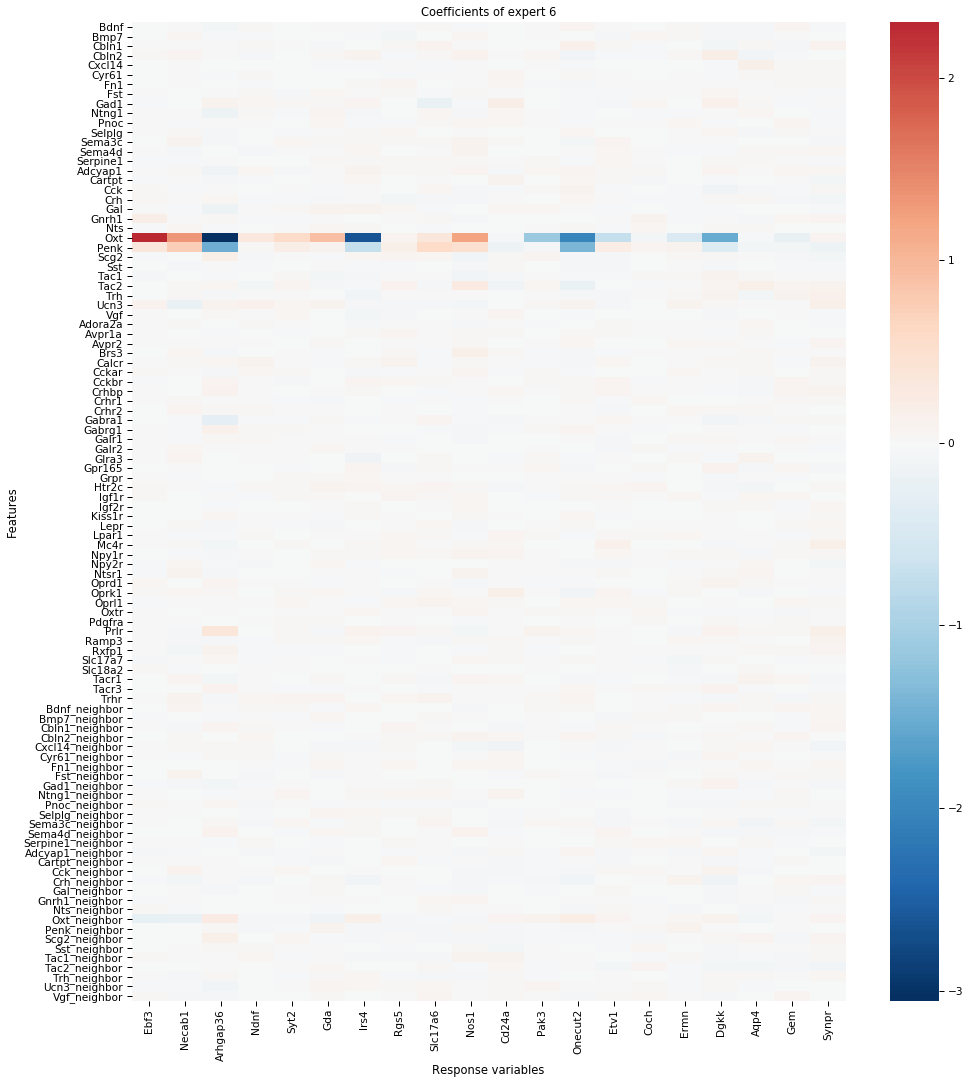

In [55]:
# model_experts is a dictionary index by 1st layer class and 2nd layer class
_weights = saved_model.model_experts[_expert[0]][_expert[1]].W[:,idx_dispersion]

df_plot = pd.DataFrame(_weights)
df_plot.index = total_regulators_neighbor_c
df_plot.columns = response_list_dispersion
plt.figure(figsize=(16,18))
sns.heatmap(df_plot, xticklabels=True, yticklabels=True, center = 0, cmap = "RdBu_r")
plt.xticks(rotation=90)
plt.ylabel("Features")
plt.xlabel("Response variables")
plt.title(f"Coefficients of expert {_expert[1]}")
plt.show()
plt.close()

### Visualize experts' conditional covariance matrix (omega)

In [53]:
sns.set_context("paper", font_scale=1.2) 

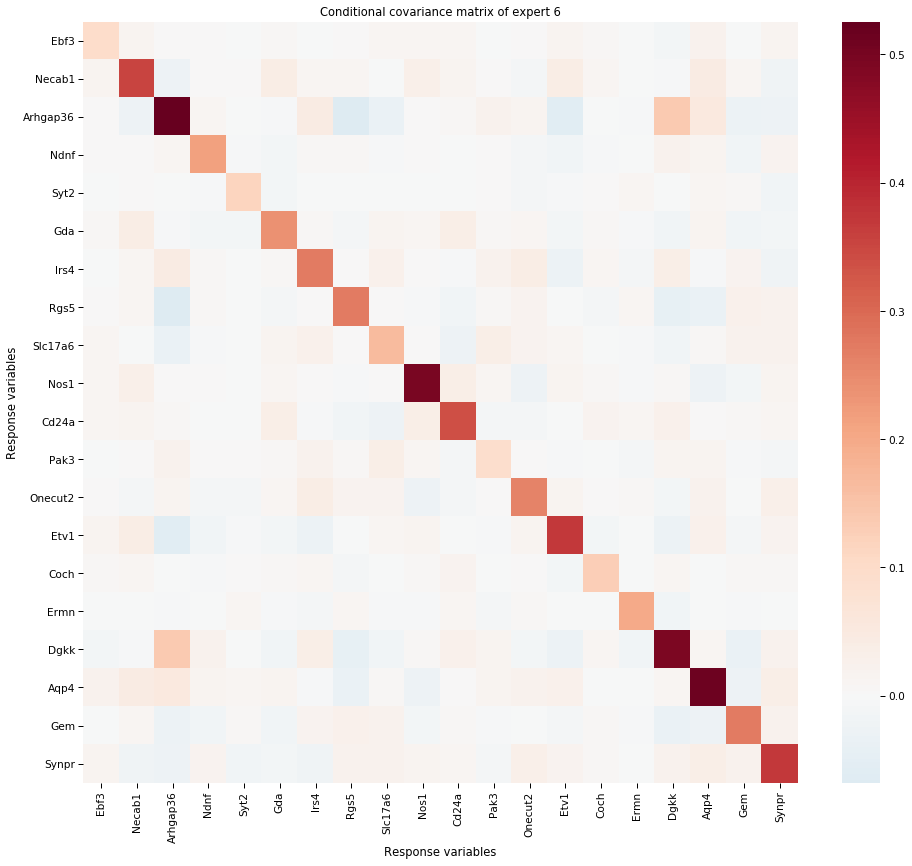

In [56]:
_omega = saved_model.model_experts[_expert[0]][_expert[1]].omega
_omega = _omega[:,idx_dispersion][idx_dispersion,:]
cutoff = 100

df_plot = pd.DataFrame(_omega[:,:cutoff][:cutoff,:])
df_plot.index = response_list_dispersion[:cutoff]
df_plot.columns = response_list_dispersion[:cutoff]
plt.figure(figsize=(16,14))
sns.heatmap(df_plot, xticklabels=True, yticklabels=True, center = 0, cmap = "RdBu_r")
plt.ylabel("Response variables")
plt.xlabel("Response variables")
plt.title(f"Conditional covariance matrix of expert {_expert[1]}")
plt.show()
plt.close()

### Visualize classifier coefficients for different experts

In [57]:
coefs = saved_model.model_gates[0].coef_[:,:102]

In [58]:
df_plot = pd.DataFrame(coefs.T)
df_plot.index = total_regulators_neighbor_c

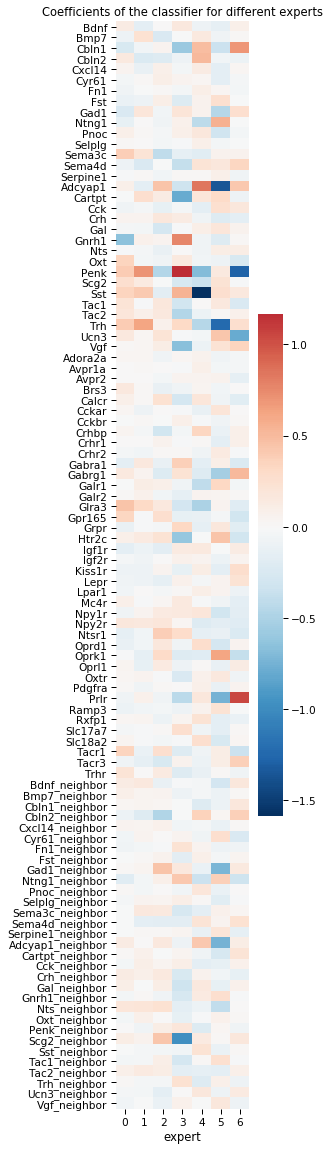

In [59]:
plt.figure(figsize=(3,20))
ax=sns.heatmap(df_plot,center = 0, cmap = "RdBu_r")
plt.xlabel('expert')
plt.title("Coefficients of the classifier for different experts")
plt.show()
plt.close()

## Other configurations 

* Currently support 2 layers of classifiers
* Different experts and gates models can be used
    1. experts: MROTS, linear regresion, LASSO
    2. gates: logistic regression, decision trees 


### 2 layers of classifiers

In [61]:
# ------ set parameters ------
n_classes_0 = 2
n_classes_1 = 3
model_name_gates = 'logistic'
model_name_experts = 'mrots'
num_response = Y_train.shape[1]
tolerance = 3

if current_cell_type not in ['OD Mature 2', 'Astrocyte', 'Endothelial 1']:
    # soft weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = True
    partial_fit_expert = True

else:
    # hard weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = False
    partial_fit_expert = False

print(f"Parameters for MESSI: number of classes at level 1: {n_classes_0}, level 2: {n_classes_1}\n\
      model for gates: {model_name_gates}, model for experts: {model_name_experts}\n\
      if used soft weights: {soft_weights}")

# ------ initialize randomly ------
hier_labels = None

# ------ construct MESSI  ------
model = hme(n_classes_0, n_classes_1, model_name_gates, model_name_experts, num_response,
            init_labels_1=hier_labels, soft_weights=soft_weights,
            partial_fit_expert=partial_fit_expert, n_epochs=n_epochs, tolerance=tolerance)
# train
model.train(X_train, X_train_clf_1, X_train_clf_2, Y_train)

Parameters for MESSI: number of classes at level 1: 2, level 2: 3
      model for gates: logistic, model for experts: mrots
      if used soft weights: True
------ epoch 1 ------
Best score: 1000000000.0
Current score: 89565.82661991609
level 1 gate error: 0.6919554685116982
level 2 gate error: [1.071365244253554, 1.0693476722882027]
experts error: [15071.500369561696, 14470.866257787207, 15660.177560502587, 14490.28958170832, 14365.774162304855, 15504.386019666377]
------ epoch 2 ------
Best score: 89565.82661991609
Current score: 86913.38381425475
level 1 gate error: 0.6890802779947304
level 2 gate error: [0.999185720322589, 0.997040253393415]
experts error: [14421.340793488249, 14104.448477553073, 15280.395031601587, 13966.573264291565, 13784.997073526973, 15352.943867541591]
------ epoch 3 ------
Best score: 86913.38381425475
Current score: 81968.41326261954
level 1 gate error: 0.6858521034698951
level 2 gate error: [0.9011553420828995, 0.8992320551782081]
experts error: [13464.880

#### make predictions

In [63]:
Y_hat_final = model.predict(X_test, X_test_clf_1, X_test_clf_2)
print(f"Mean absolute value : {(abs(Y_test - Y_hat_final).mean(axis=1)).mean()}")

Mean absolute value : 0.5833640404250073


### Use other models: e.g., use linear regression as the experts

In [64]:
# ------ set parameters ------
n_classes_0 = 1
if grid_search:
    n_classes_1 = gs.best_params['n_classes_1']
else:
    n_classes_1 = n_classes_1
model_name_gates = 'logistic'
model_name_experts = 'linear'
num_response = Y_train.shape[1]
tolerance = 3

if current_cell_type not in ['OD Mature 2', 'Astrocyte', 'Endothelial 1']:
    # soft weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = True
    partial_fit_expert = True

else:
    # hard weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = False
    partial_fit_expert = False

print(f"Parameters for MESSI: number of classes at level 1: {n_classes_0}, level 2: {n_classes_1}\n\
      model for gates: {model_name_gates}, model for experts: {model_name_experts}\n\
      if used soft weights: {soft_weights}")

# ------ initialize randomly ------
hier_labels = None

# ------ construct MESSI  ------
model = hme(n_classes_0, n_classes_1, model_name_gates, model_name_experts, num_response,
            init_labels_1=hier_labels, soft_weights=soft_weights,
            partial_fit_expert=partial_fit_expert, n_epochs=n_epochs, tolerance=tolerance)
# train
model.train(X_train, X_train_clf_1, X_train_clf_2, Y_train)

Parameters for MESSI: number of classes at level 1: 1, level 2: 7
      model for gates: logistic, model for experts: linear
      if used soft weights: True


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:206: UserWarning: Warining: partial fit for linear regression is same as complete fit when                 using all training samples to fit
  using all training samples to fit")


------ epoch 1 ------
Best score: 1000000000.0
Current score: 88546.06169302596
level 1 gate error: 0
level 2 gate error: [1.9031245393016056]
experts error: [12223.525966566483, 12273.87885764563, 12978.425157727943, 12777.78401875628, 12784.015480475458, 12282.292164017977, 13224.236923296872]
------ epoch 2 ------
Best score: 88546.06169302596
Current score: 86237.05231006198
level 1 gate error: 0
level 2 gate error: [1.7842779736908123]
experts error: [11819.375951326616, 11982.651784686803, 12711.31688440308, 12152.932160669756, 12645.37443189535, 12014.862519901939, 12908.75429920473]
------ epoch 3 ------
Best score: 86237.05231006198
Current score: 80903.70679740388
level 1 gate error: 0
level 2 gate error: [1.5992135853849596]
experts error: [10975.019401175416, 11504.981106646997, 12050.1566992315, 11249.570289123403, 11365.213994503045, 11199.399720826534, 12557.7663723116]
------ epoch 4 ------
Best score: 80903.70679740388
Current score: 76800.33284294143
level 1 gate erro

#### make predictions

In [65]:
Y_hat_final = model.predict(X_test, X_test_clf_1, X_test_clf_2)
print(f"Mean absolute value : {(abs(Y_test - Y_hat_final).mean(axis=1)).mean()}")

Mean absolute value : 0.5912492067945334
